In [1]:
import os  
import glob
import shutil
import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import PIL 
import random
import numpy as np
import matplotlib.pyplot as plt 

from PIL import Image

import cv2

In [2]:
random_seed = 124
np.random.seed(random_seed)

In [3]:
data_entry = pd.read_csv("C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/archive1/Data_Entry_2017.csv")
data_entry

Image Index          Finding Labels  Follow-up #  Patient ID  \
0       00000001_000.png            Cardiomegaly            0           1   
1       00000001_001.png  Cardiomegaly|Emphysema            1           1   
2       00000001_002.png   Cardiomegaly|Effusion            2           1   
3       00000002_000.png              No Finding            0           2   
4       00000003_000.png                  Hernia            0           3   
...                  ...                     ...          ...         ...   
112115  00030801_001.png          Mass|Pneumonia            1       30801   
112116  00030802_000.png              No Finding            0       30802   
112117  00030803_000.png              No Finding            0       30803   
112118  00030804_000.png              No Finding            0       30804   
112119  00030805_000.png              No Finding            0       30805   

        Patient Age Patient Gender View Position  OriginalImage[Width  \
0                58              M            PA                 2682   
1                58              M            PA                 2894   
2                58              M            PA                 2500   
3                81              M            PA                 2500   
4                81              F            PA                 2582   
...             ...            ...           ...                  ...   
112115           39              M            PA                 2048   
112116           29              M            PA                 2048   
112117           42              F            PA                 2048   
112118           30              F            PA                 2048   
112119           27              M            PA                 2048   

        Height]  OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0          2749                        0.143  0.143          NaN  
1          2729                        0.143  0.143          NaN  
2          2048                        0.168  0.168          NaN  
3          2048                        0.171  0.171          NaN  
4          2991                        0.143  0.143          NaN  
...         ...                          ...    ...          ...  
112115     2500                        0.168  0.168          NaN  
112116     2500                        0.168  0.168          NaN  
112117     2500                        0.168  0.168          NaN  
112118     2500                        0.168  0.168          NaN  
112119     2500                        0.171  0.171          NaN  

[112120 rows x 12 columns]

In [4]:
data_entry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


In [5]:
labels = list(data_entry['Finding Labels'].unique())
print(f'Neste dataset temos: {len(labels)} labels\n\n\n\n')
category_counts = data_entry['Finding Labels'].value_counts()
print(category_counts)

Neste dataset temos: 836 labels




Finding Labels
No Finding                                                         60361
Infiltration                                                        9547
Atelectasis                                                         4215
Effusion                                                            3955
Nodule                                                              2705
                                                                   ...  
Atelectasis|Consolidation|Edema|Effusion|Infiltration|Pneumonia        1
Atelectasis|Consolidation|Effusion|Emphysema|Mass|Pneumothorax         1
Cardiomegaly|Effusion|Pleural_Thickening|Pneumothorax                  1
Edema|Infiltration|Pneumothorax                                        1
Atelectasis|Consolidation|Mass|Pleural_Thickening|Pneumothorax         1
Name: count, Length: 836, dtype: int64


In [6]:
valid_labels = ['No Finding', 'Infiltration', 'Atelectasis', 'Effusion', 'Nodule', 'Pneumothorax', 'Mass' ]

# Filter the DataFrame to keep only rows with valid labels
filtered_df = data_entry[data_entry['Finding Labels'].isin(valid_labels)]
filtered_df.head()

Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
3   00000002_000.png     No Finding            0           2           81   
13  00000005_000.png     No Finding            0           5           69   
14  00000005_001.png     No Finding            1           5           69   
15  00000005_002.png     No Finding            2           5           69   
16  00000005_003.png     No Finding            3           5           69   

   Patient Gender View Position  OriginalImage[Width  Height]  \
3               M            PA                 2500     2048   
13              F            PA                 2048     2500   
14              F            AP                 2500     2048   
15              F            AP                 2500     2048   
16              F            PA                 2992     2991   

    OriginalImagePixelSpacing[x     y]  Unnamed: 11  
3                         0.171  0.171          NaN  
13                        0.168  0.168          NaN  
14                        0.168  0.168          NaN  
15                        0.168  0.168          NaN  
16                        0.143  0.143          NaN

In [7]:
qnt_labels = filtered_df['Finding Labels'].value_counts()
qnt_labels

Finding Labels
No Finding      60361
Infiltration     9547
Atelectasis      4215
Effusion         3955
Nodule           2705
Pneumothorax     2194
Mass             2139
Name: count, dtype: int64

Retirar Pneumonia, No findings = 15 K. Testar Data Augumentation depois

criar outro ambiente virtual

Deixando somente 15000 imagens do tipo 'No Finding'

In [8]:
df = filtered_df

# Filter 'No Finding' rows and keep exactly 15000
no_finding_rows = df[df['Finding Labels'] == 'No Finding']
rows_to_keep = no_finding_rows.sample(n=15000, random_state=42)  # Keep exactly 15000 'No Finding' rows

# Filter the DataFrame to keep 'Finding' rows and the selected 'No Finding' rows
result_df = pd.concat([df[df['Finding Labels'] != 'No Finding'], rows_to_keep])

qnt_labels = result_df['Finding Labels'].value_counts()
qnt_labels

Finding Labels
No Finding      15000
Infiltration     9547
Atelectasis      4215
Effusion         3955
Nodule           2705
Pneumothorax     2194
Mass             2139
Name: count, dtype: int64

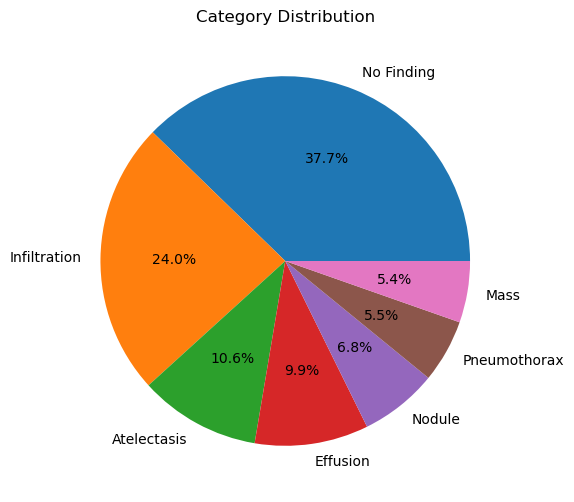

In [9]:
# Count the occurrences of each category
category_counts = result_df['Finding Labels'].value_counts()

# Plot a pie chart
plt.figure(figsize=(6, 6))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%')
plt.title('Category Distribution')
plt.show()

Obs.: É interessante testar com o dataset balanceado também.

In [10]:
columns_to_eliminate = [2,3,4,5,6,7,8,9,10,11]  # Eliminate the second column (column at index 1)

# Eliminate columns based on their column number
result_df = result_df.drop(filtered_df.columns[columns_to_eliminate], axis=1)
result_df.head(6)

Image Index Finding Labels
19  00000005_006.png   Infiltration
25  00000008_002.png         Nodule
27  00000010_000.png   Infiltration
28  00000011_000.png       Effusion
33  00000011_005.png   Infiltration
34  00000011_006.png    Atelectasis

In [11]:
num_images = len(result_df)
num_train=int(num_images*0.9)
num_test=int(num_images*0.05)
num_dev=int(num_images*0.05)

print(f'Quantidade de imagens para treino    é  {num_train} imagens')
print(f'Quantidade de imagens para validação é  {num_test} imagens')
print(f'Quantidade de imagens para teste     é  {num_dev} imagens')

Quantidade de imagens para treino    é  35779 imagens
Quantidade de imagens para validação é  1987 imagens
Quantidade de imagens para teste     é  1987 imagens


## Movendo todas as imagens para uma única pasta

In [12]:
source_folders = [
    'C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/archive1/images_001/images',
    'C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/archive1/images_002/images',
    'C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/archive1/images_003/images',
    'C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/archive1/images_004/images',
    'C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/archive1/images_005/images',
    'C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/archive1/images_006/images',
    'C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/archive1/images_007/images',
    'C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/archive1/images_008/images',
    'C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/archive1/images_009/images',
    'C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/archive1/images_010/images',
    'C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/archive1/images_011/images',
    'C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/archive1/images_012/images'
]

# Destination folder where you want to move the files
destination_folder = r'C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/imagens'

# Create the destination folder if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

# Iterate through the source folders
for source_folder in source_folders:
    # Get a list of files in the source folder
    files_to_move = os.listdir(source_folder)

    # Iterate through the files and move them to the destination folder
    for file_to_move in files_to_move:
        source_path = os.path.join(source_folder, file_to_move)
        destination_path = os.path.join(destination_folder, file_to_move)

        # Check if the file already exists in the destination folder
        if os.path.exists(destination_path):
            # You can handle the case where a file with the same name already exists here
            # For example, you can rename the file before moving it.
            pass

        # Move the file to the destination folder
        shutil.move(source_path, destination_path)

        print(f"Moved '{file_to_move}' to '{destination_folder}'")

print("All files moved successfully.")


All files moved successfully.


## Acrescentando o caminho das imagens no dataset

In [13]:
result_df.head(4)

Image Index Finding Labels
19  00000005_006.png   Infiltration
25  00000008_002.png         Nodule
27  00000010_000.png   Infiltration
28  00000011_000.png       Effusion

In [14]:

# Caminho das imagens
image_path = "C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/imagens/"

# Acrescentar o caminho ao 'Image Index'
result_df['Path Image'] = image_path + result_df['Image Index']
result_df.head(5)

Image Index Finding Labels  \
19  00000005_006.png   Infiltration   
25  00000008_002.png         Nodule   
27  00000010_000.png   Infiltration   
28  00000011_000.png       Effusion   
33  00000011_005.png   Infiltration   

                                           Path Image  
19  C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHE...  
25  C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHE...  
27  C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHE...  
28  C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHE...  
33  C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHE...

In [15]:
#Para conferir
result_df.to_csv('teste.csv')

## Criando as pastas para treinamento, teste e validação

In [16]:
# Caminho base das imagens
source_folder = os.path.normpath('C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/imagens')
# C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST
# Paths to the destination folders
train_folder = 'train'
test_folder = 'test'
validation_folder = 'valid'

# Check if the destination folders already exist, and create them if not
for folder in [train_folder, test_folder, validation_folder]:
    destination = os.path.join('C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST', folder)
    if not os.path.exists(destination):
        os.makedirs(destination)  # Use os.makedirs para criar os diretórios recursivamente
    else:
        print(f"Folder '{folder}' already exists. Skipping creation.")


In [17]:
result_df

Image Index Finding Labels  \
19      00000005_006.png   Infiltration   
25      00000008_002.png         Nodule   
27      00000010_000.png   Infiltration   
28      00000011_000.png       Effusion   
33      00000011_005.png   Infiltration   
...                  ...            ...   
55733   00013946_003.png     No Finding   
3224    00000854_000.png     No Finding   
108527  00029437_003.png     No Finding   
66353   00016410_024.png     No Finding   
105483  00028357_009.png     No Finding   

                                               Path Image  
19      C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHE...  
25      C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHE...  
27      C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHE...  
28      C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHE...  
33      C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHE...  
...                                                   ...  
55733   C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHE...  
3224    C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHE...  
108527  C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHE...  
66353   C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHE...  
105483  C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHE...  

[39755 rows x 3 columns]

In [18]:
train_prop = 0.8  # Proporção de treinamento
test_prop = 0.1  # Proporção de teste
val_prop = 0.1  # Proporção de validação

# Obtenha a lista de rótulos únicos na coluna 'Finding Labels'
unique_labels = result_df['Finding Labels'].unique()

# Crie DataFrames vazios para cada conjunto
train_df = pd.DataFrame(columns=result_df.columns)
test_df = pd.DataFrame(columns=result_df.columns)
valid_df = pd.DataFrame(columns=result_df.columns)


# Para cada rótulo único, divida os dados em treino, teste e validação
for label in unique_labels:
    label_data = result_df[result_df['Finding Labels'] == label]
    num_samples = len(label_data)
    num_train = int(num_samples * train_prop)
    num_test = int(num_samples * test_prop)
    num_val = num_samples - num_train - num_test

    train_df = pd.concat([train_df, label_data[:num_train]])
    test_df = pd.concat([test_df, label_data[num_train:num_train + num_test]])
    valid_df = pd.concat([valid_df, label_data[num_train + num_test:]])

# Agora você tem três DataFrames com as proporções desejadas para cada rótulo


In [19]:
len(train_df[train_df['Finding Labels'] == 'No Finding']), len(test_df[test_df['Finding Labels'] == 'No Finding']), len(valid_df[valid_df['Finding Labels'] == 'No Finding'])

(12000, 1500, 1500)

In [20]:
labels = ['No Finding', 'Infiltration', 'Atelectasis', 'Effusion', 'Nodule', 'Pneumothorax', 'Mass']

In [21]:
qnt_labels

Finding Labels
No Finding      15000
Infiltration     9547
Atelectasis      4215
Effusion         3955
Nodule           2705
Pneumothorax     2194
Mass             2139
Name: count, dtype: int64

In [22]:
for i in labels:
    print(len(valid_df[valid_df['Finding Labels'] == i]))

1500
956
422
396
271
220
215


In [23]:
for i in labels:
    print(len(train_df[train_df['Finding Labels'] == i]))

12000
7637
3372
3164
2164
1755
1711


In [24]:
for i in labels:
    print(len(test_df[test_df['Finding Labels'] == i]))

1500
954
421
395
270
219
213


## Colocando as imagens em subpastas

In [25]:
qnt_labels = result_df['Finding Labels'].value_counts()
qnt_labels

Finding Labels
No Finding      15000
Infiltration     9547
Atelectasis      4215
Effusion         3955
Nodule           2705
Pneumothorax     2194
Mass             2139
Name: count, dtype: int64

In [26]:
train_df = train_df.reset_index(drop=True)
train_df.head()

Image Index Finding Labels  \
0  00000005_006.png   Infiltration   
1  00000010_000.png   Infiltration   
2  00000011_005.png   Infiltration   
3  00000011_007.png   Infiltration   
4  00000013_007.png   Infiltration   

                                          Path Image  
0  C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHE...  
1  C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHE...  
2  C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHE...  
3  C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHE...  
4  C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHE...

In [27]:
test_df = test_df.reset_index(drop=True)
test_df.head()

Image Index Finding Labels  \
0  00023688_002.png   Infiltration   
1  00023715_000.png   Infiltration   
2  00023722_001.png   Infiltration   
3  00023736_000.png   Infiltration   
4  00023769_000.png   Infiltration   

                                          Path Image  
0  C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHE...  
1  C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHE...  
2  C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHE...  
3  C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHE...  
4  C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHE...

In [28]:
valid_df = valid_df.reset_index(drop=True)
valid_df.head()

Image Index Finding Labels  \
0  00027442_000.png   Infiltration   
1  00027442_008.png   Infiltration   
2  00027443_000.png   Infiltration   
3  00027446_000.png   Infiltration   
4  00027450_000.png   Infiltration   

                                          Path Image  
0  C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHE...  
1  C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHE...  
2  C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHE...  
3  C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHE...  
4  C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHE...

In [29]:

def move_images_to_subfolders(source_folder, base_dest_path, dataframe):
    # Mapping of labels to subfolder names
    label_to_subfolder = {
        'No Finding': 'No_Finding',
        'Infiltration': 'Infiltration',
        'Atelectasis': 'Atelectasis',
        'Effusion': 'Effusion',
        'Nodule': 'Nodule',
        'Pneumothorax': 'Pneumothorax',
        'Mass': 'Mass'
    }

    # Iterate through the DataFrame and move images to respective subfolders
    for index, row in dataframe.iterrows():
        image_filename = row['Image Index']
        finding_label = row['Finding Labels']

        # Get the corresponding subfolder for the label
        subfolder = label_to_subfolder.get(finding_label, 'Other')

        # Ensure the subfolder exists
        subfolder_path = f'{base_dest_path}/{subfolder}'
        os.makedirs(subfolder_path, exist_ok=True)

        # Move the image to the subfolder
        source_path = f'{source_folder}/{image_filename}' 
        destination_path = f'{subfolder_path}/{image_filename}'

        
        print(f'Moved {source_path} to {destination_path}')
        shutil.copy(source_path, destination_path)
        
        dataframe['Path Image'][index] = destination_path
        
    return dataframe

base_path_dest = 'C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/test'
test_df = move_images_to_subfolders('C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/imagens', base_path_dest, test_df)


Moved C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/imagens/00023688_002.png to C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/test/Infiltration/00023688_002.png
Moved C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/imagens/00023715_000.png to C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/test/Infiltration/00023715_000.png
Moved C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/imagens/00023722_001.png to C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/test/Infiltration/00023722_001.png
Moved C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/imagens/00023736_000.png to C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/test/Infiltration/00023736_000.png
Moved C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/imagens/00023769_000.png to C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/test/Infiltration/00023769_000.png
Moved C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/imagens/00023844_000.png to C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/test/Infiltration/00023844_000.pn

In [30]:
base_path_dest = 'C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/valid'
valid_df = move_images_to_subfolders('C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/imagens', base_path_dest, valid_df)

Moved C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/imagens/00027442_000.png to C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/valid/Infiltration/00027442_000.png
Moved C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/imagens/00027442_008.png to C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/valid/Infiltration/00027442_008.png
Moved C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/imagens/00027443_000.png to C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/valid/Infiltration/00027443_000.png
Moved C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/imagens/00027446_000.png to C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/valid/Infiltration/00027446_000.png
Moved C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/imagens/00027450_000.png to C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/valid/Infiltration/00027450_000.png
Moved C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/imagens/00027451_000.png to C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/valid/Infiltration/00027451_

In [31]:
base_path_dest = 'C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/train'
train_df = move_images_to_subfolders('C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/imagens', base_path_dest, train_df)

Moved C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/imagens/00000005_006.png to C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/train/Infiltration/00000005_006.png
Moved C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/imagens/00000010_000.png to C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/train/Infiltration/00000010_000.png
Moved C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/imagens/00000011_005.png to C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/train/Infiltration/00000011_005.png
Moved C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/imagens/00000011_007.png to C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/train/Infiltration/00000011_007.png
Moved C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/imagens/00000013_007.png to C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/train/Infiltration/00000013_007.png
Moved C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/imagens/00000013_046.png to C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/train/Infiltration/00000013_

In [32]:
train_df.to_csv('C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/train_df.csv')
test_df.to_csv('C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/test_df.csv')
valid_df.to_csv('C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/valid_df.csv')
result_df.to_csv('C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/result_df.csv')